In [2]:
from pprint import pprint

import numpy as np
import matplotlib.pyplot as plt

from anguilla.optimizers.mocma import MOCMA
import anguilla.fitness.benchmark as benchmark

In [8]:
def safe_name(name):
    return name.replace("/", "NA").replace("|", "A")

def population_plot(ax, fn, optimizer, xscale='linear', yscale='linear'):
    if fn.has_known_pareto_front:
        front = fn.pareto_front()
        if fn.has_continuous_pareto_front:
            ax.plot(
                front[0],
                front[1],
                color="red",
                linestyle="-",
                marker=None,
                label="True",
            )
        else:
            ax.plot(
                front[0],
                front[1],
                color="red",
                linestyle="",
                marker=".",
                label="True",
            )
    fitness = optimizer.best.fitness
    ax.plot(
        fitness[:, 0],
        fitness[:, 1],
        marker="x",
        linestyle="",
        label=f"Trial",
    )
    volume = optimizer.indicator(fitness)
    ax.set_title("{} evaluations, vol={:.6E})".format(optimizer.evaluation_count, volume))
    ax.set_ylabel("Second objective")
    ax.set_xlabel("First objective")
    ax.set_xscale(xscale)
    ax.set_yscale(yscale)
    ax.legend()
        
def progression_plots(
    get_fn,
    n_parents=20,
    n_offspring=None,
    success_notion="population",
    initial_step_size=1.0,
    reference=None,
    plot_at=[0, 1000, 5000, 10000, 50000, 100000],
    region_bounds=None,
    rng=None,
    sharex=False,
    sharey=False,
):
    if n_offspring is None:
        n_offspring = n_parents
    fn = get_fn(rng)
    parent_points = fn.random_points(
        n_parents, region_bounds=region_bounds
    )
    parent_fitness = fn(parent_points)
    optimizer = MOCMA(
        parent_points,
        parent_fitness,
        n_offspring=n_offspring,
        rng=rng,
        success_notion=success_notion,
        max_evaluations=max(plot_at),
    )
    if reference is not None:
        optimizer.indicator.reference = reference
        
    n_plots = len(plot_at) if len(plot_at) % 2 == 0 else len(plot_at) + 1
    n_rows = n_plots // 2
    fig = plt.figure(figsize=(12, n_rows * 3.5))
    axs = fig.subplots(n_rows, 2, sharex=sharex, sharey=sharey).flatten()
    i = 0
    while not optimizer.stop.triggered:
        if optimizer.evaluation_count in plot_at:
            population_plot(axs[i], fn, optimizer)
            i += 1
        points = optimizer.ask()
        if fn.has_constraints:
            optimizer.tell(*fn.evaluate_with_penalty(points))
        else:
            optimizer.tell(fn(points))
    population_plot(axs[i], fn, optimizer)
    fig.suptitle(
        """{} $\mathbb{{R}}^{{{}}} \mapsto """
        """\mathbb{{R}}^{}$ using {}""".format(
            fn.qualified_name,
            fn.n_dimensions,
            fn.n_objectives,
            optimizer.qualified_name,
        )
    )
    folder_name = success_notion
    if n_offspring == 1:
        folder_name = f"steady-{success_notion}"
    fig.tight_layout()
    fig.savefig(f"output/{folder_name}/{safe_name(fn.name)}.png", bbox_inches="tight")

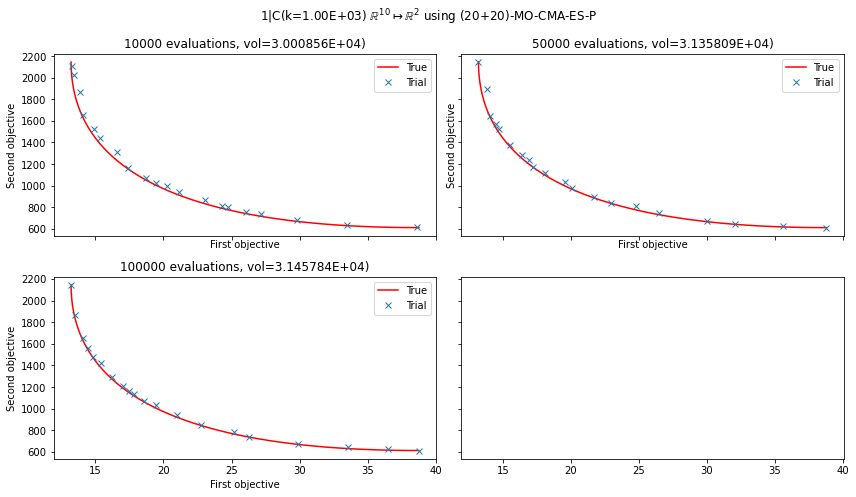

In [9]:
progression_plots(
    lambda rng: benchmark.MOQ("1|C", 10, rng=rng),
    n_parents=20,
    n_offspring=20,
    success_notion="population",
    initial_step_size=3.0,
    rng=np.random.default_rng(100),
    plot_at=[10000, 50000, 100000],
    sharex=True,
    sharey=True,
)

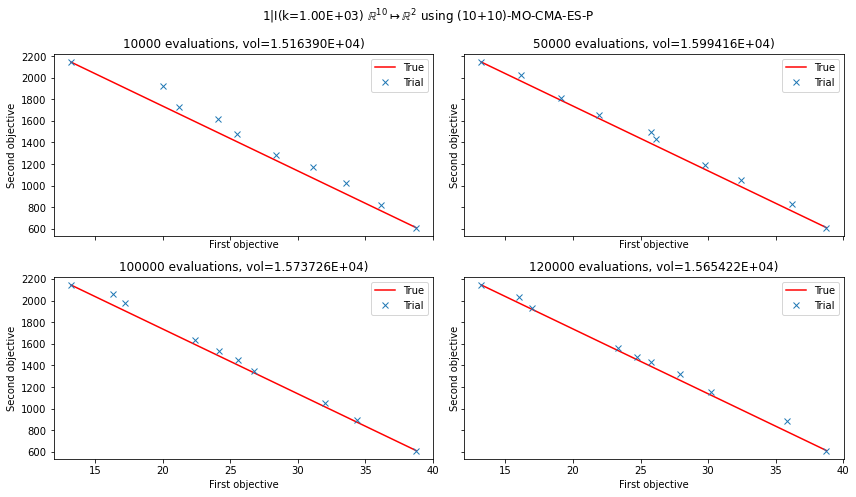

In [7]:
progression_plots(
    lambda rng: benchmark.MOQ("1|I", 10, rng=rng),
    n_parents=10,
    success_notion="population",
    initial_step_size=3.0,
    rng=np.random.default_rng(100),
    plot_at=[10000, 50000, 100000, 120000],
    sharex=True,
    sharey=True,
)

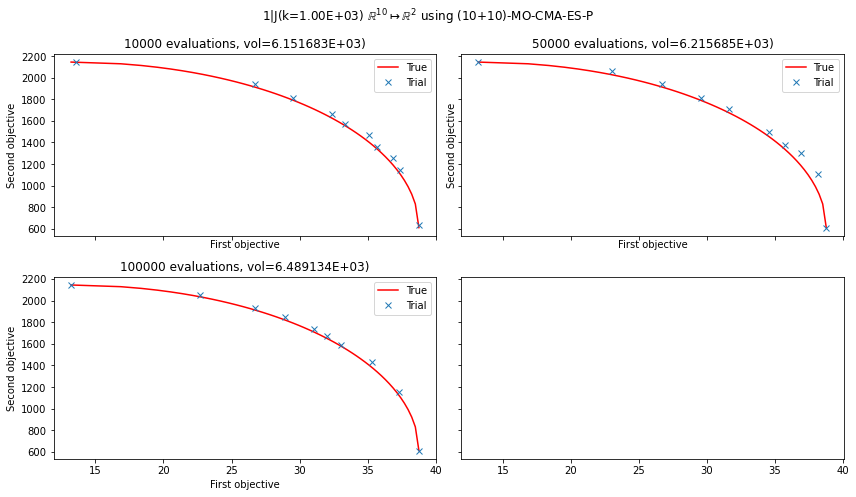

In [6]:
progression_plots(
    lambda rng: benchmark.MOQ("1|J", 10, rng=rng),
    n_parents=10,
    success_notion="population",
    initial_step_size=3.0,
    rng=np.random.default_rng(100),
    plot_at=[10000, 50000, 100000],
    sharex=True,
    sharey=True,
)